# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from unityagents import UnityEnvironment
from maddpg_agent import Agent
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 5. Initialize agents

In [6]:
random_seed = 0
train_mode = True
P1_agent = Agent(state_size, action_size, num_agents=1, random_seed=0)
P2_agent = Agent(state_size, action_size, num_agents=1, random_seed=0)

### 6. MADDPG function

In [7]:
def maddpg(n_episodes=2000, max_t=1000, print_every=100, goal_score=0.5, episodes=100):
    scores_deque = deque(maxlen=100)
    total_scores = []
    average_score = []
    max_score = -np.Inf
    max_score_episode = 0
    start_time = time.time()

    for i_episode in range(1, n_episodes + 1):
        # Reset environment
        env_info = env.reset(train_mode=train_mode)[brain_name]
        # Get current state for each agent and combine them
        states = np.reshape(env_info.vector_observations, (1,48))
        P1_agent.reset()
        P2_agent.reset()
        # Initialize the score (for each agent)
        scores = np.zeros(num_agents)

        for t in range(max_t):
            # Select an action
            action_P1 = P1_agent.act(states, add_noise=True)  # agent 0 chooses an action
            action_P2 = P2_agent.act(states, add_noise=True)  # agent 1 chooses an action
            actions = np.concatenate((action_P1, action_P2), axis=0).flatten()

            # Send actions to environment
            env_info = env.step(actions)[brain_name]

            # Get next state and combine them
            next_states = np.reshape(env_info.vector_observations, (1, 48))

            # Get reward
            rewards = env_info.rewards

            # Check if episode has finished
            done = env_info.local_done

            # Send actions to the agents
            P1_agent.step(states, actions, rewards[0], next_states, done, 0)  # agent 1 learns
            P2_agent.step(states, actions, rewards[1], next_states, done, 1)  # agent 2 learns

            # Pass states to next time step
            states = next_states
            
            # Update the scores
            scores += np.max(rewards)

            # Exit loop if episode finished
            if np.any(done):
                break

        episode_max_score = np.max(scores)
        scores_deque.append(episode_max_score)
        total_scores.append(episode_max_score)
        average_score.append(np.mean(scores_deque))

        # Save best score
        if episode_max_score > max_score:
            max_score = max_score_episode
            max_score_episode = i_episode

        # Print results
        if i_episode % print_every == 0:
            print('Episodes {:0>4d}-{:0>4d}\t Highest Reward: {:.3f}\t Lowest Reward: {:.3f}\t Average Score: {:.3f}'.format(
                i_episode-print_every, i_episode, np.max(total_scores[-print_every:]), np.min(total_scores[-print_every:]), average_score[-1]))


        # Determine if environment is solved and keep best performing models
        if average_score[-1] >= goal_score:
            print('\nEnvironment solved in {:d} episodes! \
                \nAverage Score: {:.3f} over past {:d} episodes'.format(
                    i_episode-episodes, average_score[-1], episodes))
            print('Training time = {:.5f} sec'.format(time.time() - start_time))

            # Save weights
            torch.save(P1_agent.actor_local.state_dict(), 'checkpoint_actor_P1_agent.pth')
            torch.save(P1_agent.critic_local.state_dict(), 'checkpoint_critic_P1_agent.pth')
            torch.save(P2_agent.actor_local.state_dict(), 'checkpoint_actor_P2_agent.pth')
            torch.save(P2_agent.critic_local.state_dict(), 'checkpoint_critic_P2_agent.pth')
            break

    return total_scores, average_score

### 7. Start training

In [8]:
scores, avgs = maddpg()

Episodes 0000-0100	 Highest Reward: 0.300	 Lowest Reward: 0.000	 Average Score: 0.010
Episodes 0100-0200	 Highest Reward: 0.400	 Lowest Reward: 0.000	 Average Score: 0.029
Episodes 0200-0300	 Highest Reward: 0.400	 Lowest Reward: 0.000	 Average Score: 0.048
Episodes 0300-0400	 Highest Reward: 0.700	 Lowest Reward: 0.000	 Average Score: 0.147
Episodes 0400-0500	 Highest Reward: 1.100	 Lowest Reward: 0.000	 Average Score: 0.197

Environment solved in 464 episodes!                 
Average Score: 0.524 over past 100 episodes
Training time = 263.56140 sec


### 8. Plot results 

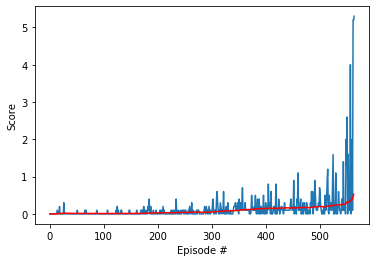

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.plot(np.arange(len(scores)), avgs, c='r', label='Average Score avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 9. Close environment 

In [10]:
env.close()